In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import math
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from mamba import *

In [2]:
stock_name = 'EBAY'
df = yf.download(stock_name,
                 start='2016-06-01',
                 end='2019-01-26',
                 progress=False)
file_name = f'{stock_name}.csv'
df.to_csv(file_name)

In [3]:
df = pd.read_csv(file_name)
close_prices = df['Close']

In [4]:
print(close_prices.shape)

(668,)


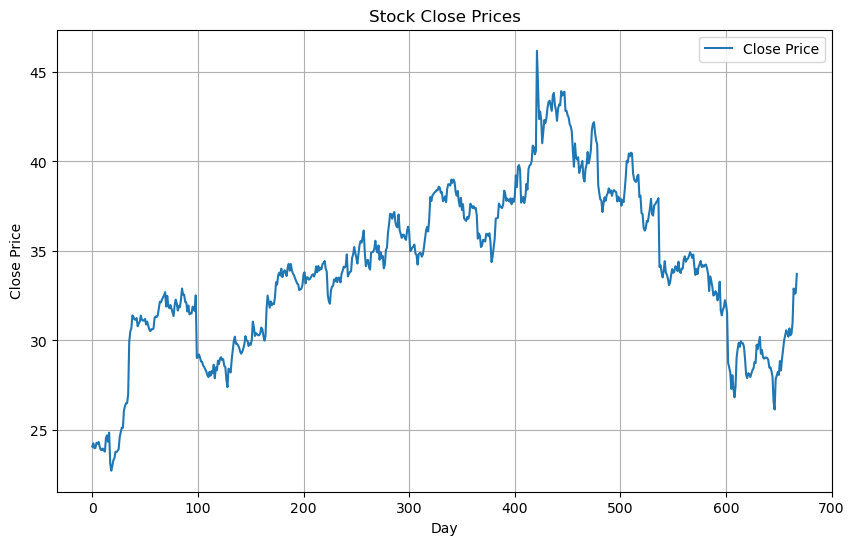

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Close Price')
plt.title('Stock Close Prices')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
pct_changes = close_prices.pct_change().dropna()*100

In [7]:
pct_changes = pct_changes.values.reshape(-1, 1)

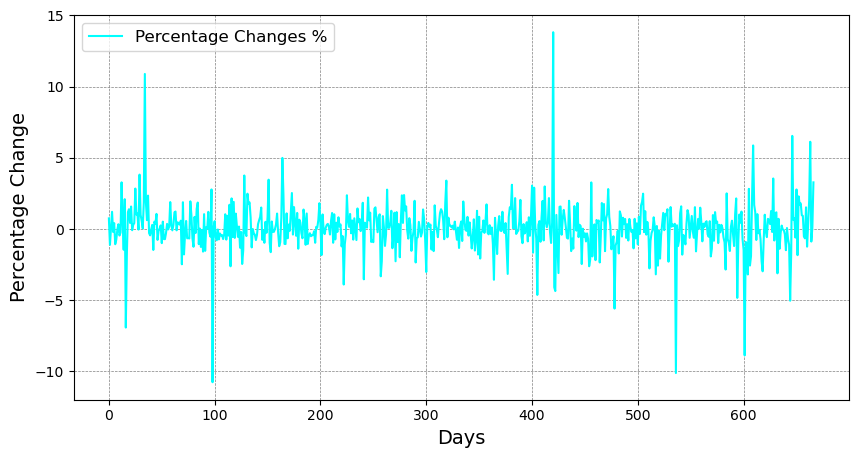

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes %')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pct_changes = scaler.fit_transform(pct_changes)

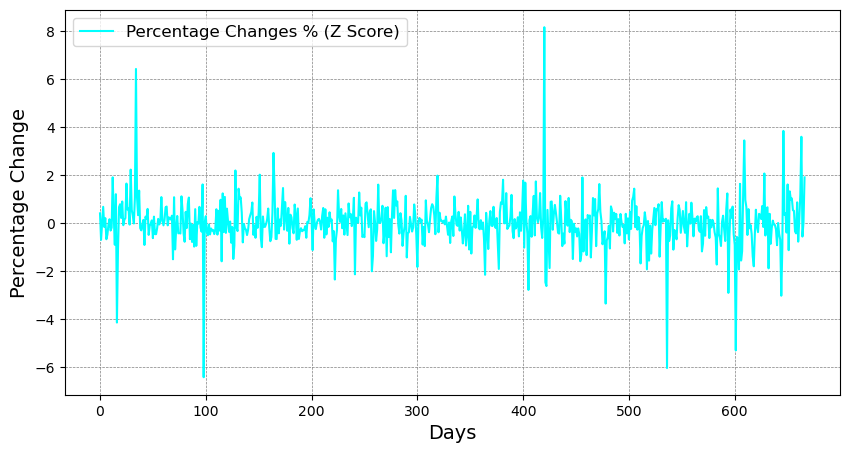

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes % (Z Score)')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

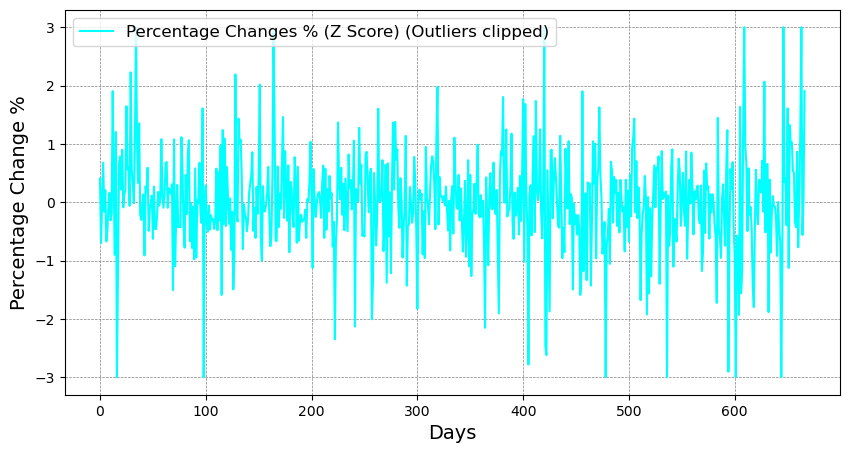

In [11]:
lower_bound = -3
upper_bound = 3
pct_changes = np.clip(pct_changes, lower_bound, upper_bound)
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes % (Z Score) (Outliers clipped)')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change %', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  
plt.show()

In [12]:
print(pct_changes.shape)

(667, 1)


In [13]:
def create_time_series_windows(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step):
        historical_data = dataset[i:(i+time_step), 0]
        features.append(historical_data)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)

In [14]:
import itertools
from sklearn.metrics import f1_score
# Hiperparametre değerlerini tanımlayalım
hyperparams = {
    'time_step': [10, 20],
    'lr': [0.00005, 0.0001],
    'num_epochs': [100],
    'batch_size': [32,64],
    'd_model': [32,64],
    'd_state': [16, 8],
    'n_layers': [2, 3]
}

# Tüm kombinasyonları oluştur
param_combinations = list(itertools.product(*hyperparams.values()))
results = []

In [15]:
for i, params in enumerate(param_combinations):
    time_step, lr, num_epochs, batch_size, d_model, d_state, n_layers = params

    # Zaman serisi verisini yeniden oluştur
    X, y = create_time_series_windows(pct_changes, time_step)
    
    # Veriyi yeniden böl
    test_size = 120
    training_size = int(len(X) - test_size)
    X_train, X_test = X[0:training_size], X[training_size:len(X)]
    y_train, y_test = y[0:training_size], y[training_size:len(y)]

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)

    # Modeli yeniden tanımla
    config = MambaConfig(
        d_model=d_model,
        n_layers=n_layers,
        dt_rank='auto',
        d_state=d_state,
        expand_factor=2,
        d_conv=4,
        dt_min=0.001,
        dt_max=0.1,
        dt_init="random",
        dt_scale=1.0,
        bias=False,
        conv_bias=True,
        pscan=True
    )
    
    model = Mamba(config)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # İlk ağırlıkları kaydet
    initial_weight_filename = f"initial_weights_model_{i}.pth"
    torch.save(model.state_dict(), initial_weight_filename)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    val_dataset = TensorDataset(X_test, y_test)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    early_stopping_patience = 30
    best_loss = float('inf')
    patience_counter = 0
    
    # Eğitim döngüsü
    for epoch in range(num_epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()

            outputs = model(batch_x)
            last_outputs = outputs[:, -1, -1]

            loss = criterion(last_outputs, batch_y)
            loss.backward()
            optimizer.step()


        #validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(device), val_y.to(device)
                val_outputs = model(val_x)
                val_last_outputs = val_outputs[:, -1, -1]
                val_loss += criterion(val_last_outputs, val_y).item()

        val_loss /= len(val_loader)
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    
    # Test aşaması
    model.eval()
    X_test_tensor = X_test.clone().detach().to(device).view(-1, time_step, 1)
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)[:, -1, -1]

    y_test_pred = y_test_pred.cpu().numpy().reshape(-1, 1)
    y_test_pred = scaler.inverse_transform(y_test_pred)

    
    y_test_binary = np.where(y_test > 0, 1, 0)
    y_pred_binary = np.where(y_test_pred > 0, 1, 0)

    f1 = f1_score(y_test_binary, y_pred_binary)
    print(f"Model {i}: F1 Score = {f1:.2f}")
    results.append((params, f1, initial_weight_filename))

Model 0: F1 Score = 0.57
Model 1: F1 Score = 0.60
Model 2: F1 Score = 0.56
Model 3: F1 Score = 0.53
Early stopping at epoch 92
Model 4: F1 Score = 0.54
Early stopping at epoch 91
Model 5: F1 Score = 0.56
Model 6: F1 Score = 0.57
Early stopping at epoch 86
Model 7: F1 Score = 0.57
Model 8: F1 Score = 0.56
Model 9: F1 Score = 0.63
Model 10: F1 Score = 0.57
Model 11: F1 Score = 0.58
Model 12: F1 Score = 0.56
Model 13: F1 Score = 0.54
Model 14: F1 Score = 0.56
Model 15: F1 Score = 0.51
Early stopping at epoch 84
Model 16: F1 Score = 0.57
Early stopping at epoch 83
Model 17: F1 Score = 0.51
Early stopping at epoch 87
Model 18: F1 Score = 0.56
Early stopping at epoch 75
Model 19: F1 Score = 0.49
Early stopping at epoch 58
Model 20: F1 Score = 0.53
Early stopping at epoch 56
Model 21: F1 Score = 0.49
Early stopping at epoch 67
Model 22: F1 Score = 0.55
Early stopping at epoch 58
Model 23: F1 Score = 0.50
Model 24: F1 Score = 0.60
Model 25: F1 Score = 0.45
Model 26: F1 Score = 0.60
Model 27: F

In [16]:
print("Hiperparametre Sonuçları:")
print("---------------------------------")
for params, f1, weight_file in results:
    print(f"Params: {params}, F1 Score: {f1:.2f}, Initial Weights: {weight_file}")

Hiperparametre Sonuçları:
---------------------------------
Params: (10, 5e-05, 100, 32, 32, 16, 2), F1 Score: 0.57, Initial Weights: initial_weights_model_0.pth
Params: (10, 5e-05, 100, 32, 32, 16, 3), F1 Score: 0.60, Initial Weights: initial_weights_model_1.pth
Params: (10, 5e-05, 100, 32, 32, 8, 2), F1 Score: 0.56, Initial Weights: initial_weights_model_2.pth
Params: (10, 5e-05, 100, 32, 32, 8, 3), F1 Score: 0.53, Initial Weights: initial_weights_model_3.pth
Params: (10, 5e-05, 100, 32, 64, 16, 2), F1 Score: 0.54, Initial Weights: initial_weights_model_4.pth
Params: (10, 5e-05, 100, 32, 64, 16, 3), F1 Score: 0.56, Initial Weights: initial_weights_model_5.pth
Params: (10, 5e-05, 100, 32, 64, 8, 2), F1 Score: 0.57, Initial Weights: initial_weights_model_6.pth
Params: (10, 5e-05, 100, 32, 64, 8, 3), F1 Score: 0.57, Initial Weights: initial_weights_model_7.pth
Params: (10, 5e-05, 100, 64, 32, 16, 2), F1 Score: 0.56, Initial Weights: initial_weights_model_8.pth
Params: (10, 5e-05, 100, 6

In [ ]:
import os
pid = os.getpid()
!kill -9 $pid